In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import time
import random, argparse, logging, os
from collections import namedtuple
from minatar import Environment
import matplotlib.pyplot as plt
import numpy as np
# remove for game display
%matplotlib inline

In [2]:
NUM_FRAMES = 1000
MAX_EVALS = 5000
device = "cpu"

In [3]:
class Network(nn.Module):
    def __init__(self, in_channels, num_actions):

        super(Network, self).__init__()

        # One hidden 2D convolution layer:
        #   in_channels: variable
        #   out_channels: 4
        #   kernel_size: 3 of a 3x3 filter matrix
        #   stride: 1
        self.conv = nn.Conv2d(in_channels, 4, kernel_size=3, stride=1)

        # Final fully connected hidden layer:
        #   the number of linear unit depends on the output of the conv
        #   the output consist 32 rectified units
        def size_linear_unit(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1
        num_linear_units = size_linear_unit(10) * size_linear_unit(10) * 4
        self.fc_hidden = nn.Linear(in_features=num_linear_units, out_features=32)

        # Output layer:
        self.output = nn.Linear(in_features=32, out_features=num_actions)

    def forward(self, x):
        x = f.relu(self.conv(x))
        x = f.relu(self.fc_hidden(x.view(x.size(0), -1)))
        return self.output(x)
    
    def set_params(self, params):
        a = torch.tensor(params, device=device).float()
        torch.nn.utils.vector_to_parameters(a, self.parameters())
        
    def get_params(self):
        with torch.no_grad():
            params = self.parameters()
            vec = torch.nn.utils.parameters_to_vector(params)
        return vec.to(device).numpy()

In [4]:
def get_state(s):
    return (torch.tensor(s, device=device).permute(2, 0, 1)).unsqueeze(0).float()

In [5]:
env = Environment("breakout", sticky_action_prob=0.0, random_seed=0)
env.reset()

In [6]:
in_channels = env.state_shape()[2]
num_actions = env.num_actions()
policy_net = Network(in_channels, num_actions).to(device)

(10, 10, 4)


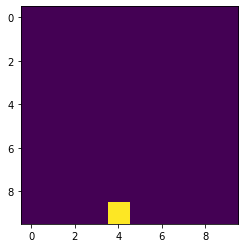

In [7]:
print(env.state().shape)
plt.imshow(env.state()[:, :, 0]);

torch.Size([1, 4, 10, 10])


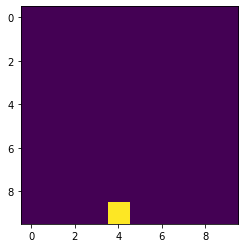

In [8]:
s = get_state(env.state())
print(s.shape)
plt.imshow(s[:, 0, :, :][0]);

In [9]:
with torch.no_grad():
    outputs = policy_net(s)
    print("outputs: ", outputs)
    print("argmax: ", torch.argmax(outputs))

outputs:  tensor([[ 0.0650,  0.0302, -0.0706,  0.1311, -0.0509,  0.0265]])
argmax:  tensor(3)


In [10]:
def play(policy_net, display=False):
    env = Environment("breakout", sticky_action_prob=0.0, random_seed=0)
    env.reset()
    is_terminated = False
    total_reward = 0.0
    t = 0
    while (not is_terminated) and t < NUM_FRAMES:
        s = get_state(env.state())
        with torch.no_grad():
            action = torch.argmax(policy_net(s))
        reward, is_terminated = env.act(action)
        total_reward += reward
        t += 1
        if display:
            env.display_state(1)
    return total_reward

In [11]:
play(policy_net, display=False)

0.0

In [12]:
genes = policy_net.get_params()
n_genes = len(genes)
print(genes, n_genes)

[-0.16466779  0.02577933 -0.09572713 ...  0.14972208 -0.06523087
  0.03031591] 8570


In [13]:
genes = np.random.randn(n_genes)
policy_net.set_params(genes)
policy_net.get_params() - genes

array([ 1.77838824e-08,  2.45324064e-08,  4.06576167e-09, ...,
       -1.07562787e-08,  2.37985318e-08,  1.95371175e-09])

In [14]:
np.random.seed(4321)
best_genes = genes
best_fit = 0.0
fits = np.zeros(MAX_EVALS)
for i in range(MAX_EVALS):
    genes = np.random.randn(n_genes)
    policy_net.set_params(genes)
    fitness = play(policy_net)
    if fitness > best_fit:
        print(i, " ", fitness)
        best_fit = fitness
        best_genes = genes.copy()
    fits[i] = best_fit

1   1.0
39   2.0
613   3.0
1074   4.0
3375   5.0


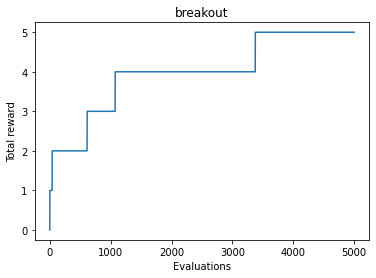

In [15]:
plt.plot(fits)
plt.xlabel("Evaluations")
plt.ylabel("Total reward")
plt.title(env.env_name);

In [16]:
policy_net.set_params(best_genes)
play(policy_net, display=False)

5.0